## Plots for Barcharts

#### Content
[GCsnap1 Timings](#GCsnap1)  
[Dask Distributed vs MPI](#dask_distibuted_mpi)   
[GCsnap2 Cluster](#gc2c)  
[SPortability of GCsnap2](#scaling)  
[MPIprofiling](#mpiprofiling)  


##### Packages and main formatting parameters

In [3]:
# executed in conda evnironment 'plotting' ./conda_envs/plotting

# packages and overall options
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.lines as lines
import matplotlib.patches as patches
import matplotlib.lines as mlines
import glob
import re

bol_paper = True

if bol_paper:
    sns.set(style='white', font='serif', font_scale=1.5)
    # fontsize for annotation
    font_size = 14
    fig_width = 9
    fig_height = 4.5
    # Set Seaborn style without grid
    plt.rcParams['xtick.major.size'] = 4
    plt.rcParams['ytick.major.size'] = 4
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True   
    # out path
    out_folder = ''
    legend_anchor=1.2
else:
    sns.set(style='white', font='sans serif', font_scale=1.3)
    # fontsize for annotation
    font_size = 14
    # figur width and height
    fig_width = 10
    fig_height = 4
    # Set Seaborn style without grid
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    # out path
    out_folder = 'presentations'
    legend_anchor=1.2

# colors
# custom_palette = sns.color_palette('colorblind')
# we use the IBM color design which looks ok for all:https://forum.shotcut.org/t/palette-for-colour-blindness/32219
ibm_colors_hex = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']

import matplotlib.colors as mcolors
# Function to lighten colors
def lighten_color(hex_color, factor=0.25):
    """Lightens the given color by blending it with white."""
    rgb = mcolors.hex2color(hex_color)  # Convert to RGB (0-1 range)
    light_rgb = [(1 - factor) * c + factor for c in rgb]  # Blend with white
    return mcolors.to_hex(light_rgb)

# Generate lightened versions of IBM colors
light_ibm_colors_hex = [lighten_color(color, factor=0.25) for color in ibm_colors_hex]

# Add three shades of grey
grey_shades = ['#D3D3D3', '#A9A9A9', '#696969']

# Combine into an extended color palette
extended_colors = ibm_colors_hex + grey_shades + light_ibm_colors_hex

custom_palette = sns.color_palette(extended_colors)

# annotateion color on columns
annotate_color='black'

# output path for svg plots
path_svg = '/users/stud/k/kruret00/PASC25/plots'

##### Helper functions

In [4]:
def format_with_decimals(value, tick_number):
    return f'{value:.1f}'

# general methods
def format_thousands_separator(x, pos):
    # x are the labels (str), if convertable to float its fine.
    try:
        return '{:,.0f}'.format(int(round(float(x),0))).replace(',', "'")
    except ValueError:
        return x

def formatter(ax, rotation=None):
    # Format the y-axis ticks with a space as a thousand separator
    ax.get_yaxis().set_major_formatter(FuncFormatter(format_thousands_separator))
    
    # Customize tick parameters
    ax.tick_params(axis='both', width=0.8)
    
    # Get the current tick labels
    tick_positions = ax.get_xticks()  # Numeric positions
    tick_labels = [item.get_text() for item in ax.get_xticklabels()]  # Original labels as strings
    
    # Preserve original labels and apply formatting
    formatted_labels = [format_thousands_separator(label, None) for label in tick_labels]
    
    ax.set_xticks(tick_positions)  # Ensure tick positions are preserved
    if rotation is None:
        ax.set_xticklabels(formatted_labels)
    else:
        ax.set_xticklabels(formatted_labels, rotation=rotation, ha='right', rotation_mode='anchor')
        
    # Format legend labels with a space as a thousand separator
    if ax.get_legend() is not None:  # Ensure there is a legend
        for label in ax.get_legend().get_texts():
            label.set_text(format_thousands_separator(label.get_text(), None))    

def make_grid(ax, plt, ygrid=True, xgrid=False):
    ax.yaxis.grid(ygrid)  # Enable the grid
    ax.xaxis.grid(xgrid)  # Enable the grid
    plt.setp(ax.get_ygridlines(), 'linestyle', '-')  # Set grid line style
    plt.setp(ax.get_ygridlines(), 'linewidth', 0.5)  # Set grid line width
    plt.setp(ax.get_ygridlines(), 'color', 'gray', 'alpha', 0.5)  # Set grid line color
    
    # Enhance grid visibility beneath the bars
    ax.set_axisbelow(True)    
    
    # Customize the box line width
    ax.spines['top'].set_linewidth(0.8)
    ax.spines['right'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    ax.spines['left'].set_linewidth(0.8)

    # Customize tick parameters
    ax.tick_params(axis='both', width=0.5, length=3)

def annotater(ax, plt, annotation_rotated = False):
    
    division = 4

    rot = 0
    if annotation_rotated:
        rot = 90
        division = 1
    
    # find the smallest height
    min_height = float('inf')
    for p in ax.patches:
        if p.get_height() > 0 and p.get_height() < min_height:
            min_height = p.get_height()
            
    # find the largest height
    max_height = float('-inf')
    for p in ax.patches:
        if p.get_height() > 0 and p.get_height() > max_height:
            max_height = p.get_height()            
    
    for p in ax.patches:
        if p.get_width() > 0:
            height = p.get_height()
            digit_count = len(f'{int(height):,}')  # Count digits in the formatted number
            text_position = height + (max_height / min_height)  / division               
            plt.text(p.get_x() + p.get_width() / 1.8, text_position,
                      format_thousands_separator(p.get_height(), None),
                      ha='center', va='bottom', rotation=rot, color=annotate_color, fontsize=font_size,
                      bbox=dict(facecolor='white', edgecolor='none', alpha=1, pad=0.1)
                      )
            
def finisher(plot_name, plt):
    # Remove the top and right spines
    #sns.despine(top=True, right=True)   

    # pack everthing into the plot size
    plt.tight_layout()

    # Save the plot as SVG
    plt.savefig(os.path.join(path_svg,out_folder,plot_name + '.svg'), format='svg', bbox_inches='tight')
    plt.show()

import matplotlib.lines as lines

### Timings GCsnap 1.0
<a id='GCsnap1'></a>

Read the GCsnap experimental data and combine them to a dataframe.
Experiments were conducted on miniHPC AMD node.
We did it twice, but the results were equally unstable, meaning experiments did just not finish. So we take the first try.

In [3]:
# load and read data
path_csv = '/users/stud/k/kruret00/PASC25/experiments_deliver/gcsnap1/results'

# all csv files
all_files = glob.glob(os.path.join(path_csv,'**','*.tsv'))

# Read all TSV files and combine them into a single DataFrame
df_list = []
for filename in all_files:
    
    folder_name = os.path.basename(os.path.split(filename)[0])
    n_targets = int(folder_name.split('_')[0])
    n_threads = int(folder_name.split('_')[2])
    n_rep = int(folder_name.split('_')[4])
    
    # column names
    col_names=['task',
           'total time (s)',
           'count',
           'max time (s)',
           'min time (s)',
           'mean time (s)',
           'std time',
           'median time (s)']
    
    # read the tsv
    df = pd.read_csv(filename, index_col=None, header=1, sep='\t', names=col_names)
    # remove the first row
    df = df.iloc[1:].reset_index(drop=True)
    del df['std time']
    
    # convert to float (as seconds) and int (count)
    df['count'] = df['count'].astype(int)
    df['max time (s)'] = df['max time (s)'].astype(float)
    df['total time (s)'] = df['total time (s)'].astype(float)
    df['min time (s)'] = df['min time (s)'].astype(float)
    df['mean time (s)'] = df['mean time (s)'].astype(float)
    df['median time (s)'] = df['median time (s)'].astype(float)
    
    # add targets and threads colum
    df['targets'] = n_targets
    df['threads'] = n_threads
    df['repetition'] = n_rep
        
    df_list.append(df)
combined_df = pd.concat(df_list, axis=0, ignore_index=True)

# save for later
df_gcsnap1 = combined_df.copy()
combined_df[(combined_df['task'] == 'All steps 0-10') &(combined_df['targets'] == 100 ) & (combined_df['threads'] == 8)]


,task,total time (s),count,max time (s),min time (s),mean time (s),median time (s),targets,threads,repetition
2811,All steps 0-10,163.624640,1,163.624640,163.624640,163.624640,163.624640,100,8,1
2848,All steps 0-10,154.589381,1,154.589381,154.589381,154.589381,154.589381,100,8,2
2885,All steps 0-10,181.483633,1,181.483633,181.483633,181.483633,181.483633,100,8,3
2922,All steps 0-10,155.713505,1,155.713505,155.713505,155.713505,155.713505,100,8,4
2959,All steps 0-10,172.311712,1,172.311712,172.311712,172.311712,172.311712,100,8,5


##### Overall runtime for different number of targets and cores

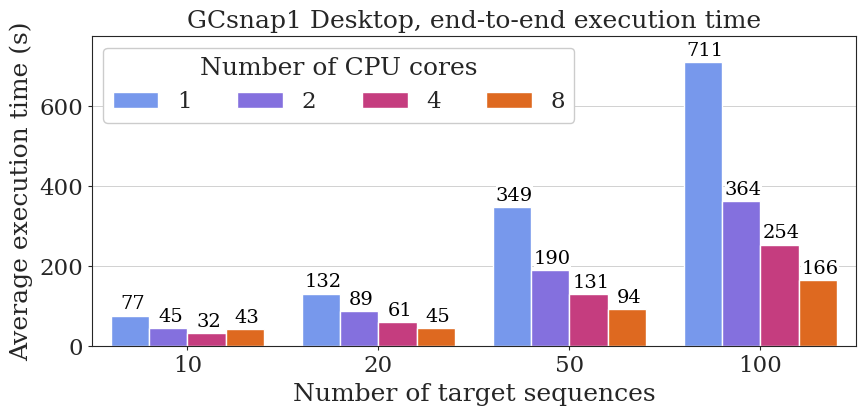

In [4]:
# plots are procuded in loops

y_axis_text = 'Average execution time (s)'

plot_loop = {
    'gcsnap1_overview' : {
        'on_hue' : 'threads',
        'on_hue_label' : 'Number of CPU cores',
        'on_y' : 'total time (s)',
        'on_y_label' : y_axis_text,
        'on_x' : 'targets',
        'on_x_label' : 'Number of target sequences',
        'columns' : ['targets', 'threads', 'repetition'],
        'filter_cols' : [
            ('task', ['All steps 0-10']),
            ('threads', [1,2,4,8]),
            ('targets', [10,20,50,100])
        ],
        'title' : 'GCsnap1 Desktop, end-to-end execution time',
        'loc' : 'upper left',    
        'ylim' : [0,775]   
    }
}

for k,v in plot_loop.items():
    df = combined_df.copy()
    # what we want to display
    on_x = v.get('on_x')
    on_x_label = v.get('on_x_label')
    on_y = v.get('on_y')
    on_y_label= v.get('on_y_label')
    on_hue = v.get('on_hue')
    on_hue_label = v.get('on_hue_label')

    # columns
    columns = v.get('columns')

    ##### Change this and the name to make and save another plot
    filter_cols = v.get('filter_cols') 
    # name of the plot
    title = v.get('title')
    plot_name = '{}'.format(k)

    # to annotate bars
    annotate=True
    # ignored if annotate=False
    annotation_rotated=False

    # Filter data
    for filt in filter_cols:
        if filt[1] is None:
            df = df[(df[filt[0]].isnull())]
        else:
            df = df[(df[filt[0]].isin(filt[1]))]
    # Sum time over steps
    data = df.groupby(columns)['total time (s)'].sum().reset_index()

    # Plot the bar plot using seaborn
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(
        data=data,
        x=on_x,
        y=on_y,
        hue=on_hue,
        estimator=np.mean, 
        errorbar=None,
        # errorbar = lambda x: (x.min(), x.max()), 
        palette=custom_palette[:data[on_hue].nunique()],
        capsize=0.1,  # Controls the size of the caps on the error bars
        err_kws={'color': 'black', 'linewidth': 1} # Width of the error bars       
    )

    # Set plot properties
    plt.xlabel(on_x_label)
    plt.ylabel(on_y_label)

    # Add thin grid lines at y-axis ticks
    make_grid(ax, plt)

    # set y axis limits for plot to fit
    if not v.get('ylim',None) is None:
        l,u = v.get('ylim')
        plt.ylim(l,u)

    # Set the title using plt.title()
    plt.title(title)

    # Place the legend at the top-right corner
    leg = plt.legend(title=on_hue_label, loc=v.get('loc'), ncol=data[on_hue].nunique())
    leg.get_frame().set_alpha(1) 

    # Format the y-axis ticks with a space as a thousand separator
    # Format legend labels with a space as a thousand separator
    formatter(ax)

    # Annotate each bar with the formatted value
    if annotate:
        annotater(ax, plt, annotation_rotated)

    # finish, save and plot
    finisher(plot_name, plt)


### Dask distributed vs MPI
<a id='dask_distibuted_mpi'></a>
This experiment is to evaluate the usability of Dask distributed vs MPI

##### Read Data

In [91]:
# path to files depending on the machine
path_csv = '/users/stud/k/kruret00/PASC25/experiments_deliver/dask_distributed_assemblies/'
    
# all csv files
all_files = glob.glob(os.path.join(path_csv,'results', '*.csv'))

# add distributed experiments
path_csv = '/users/stud/k/kruret00/PASC25/experiments/mpi_distributed_assemblies/'
    
# all csv files
all_files = glob.glob(os.path.join(path_csv,'results', '*.csv')) + all_files

# Read all CSV files and combine them into a single DataFrame
df_list = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, sep=',')
    # rename mpi column
    df.rename(columns={'ranks_per_node': 'cores_per_node'}, inplace=True)
    # ad typte of experiment to df
    df['tool'] = filename.split('/')[-3].split('_')[0]
    df_list.append(df)
combined_df = pd.concat(df_list, axis=0, ignore_index=True)
combined_df.head(10)

,n_targets,nodes,cores_per_node,step,repetition,time (s),result_length,tool
0,10000,16,16,get_files,1,0.021103,NaN,mpi
1,10000,16,16,parsed_assemblies,1,8.085497,NaN,mpi
2,10000,16,16,get_files,2,0.020957,NaN,mpi
3,10000,16,16,parsed_assemblies,2,8.226364,NaN,mpi
4,10000,16,16,get_files,3,0.020789,NaN,mpi
5,10000,16,16,parsed_assemblies,3,8.094494,NaN,mpi
6,10000,16,16,get_files,4,0.020879,NaN,mpi
7,10000,16,16,parsed_assemblies,4,8.067551,NaN,mpi
8,10000,16,16,get_files,5,0.021068,NaN,mpi
9,10000,16,16,parsed_assemblies,5,8.226536,NaN,mpi


##### Plots

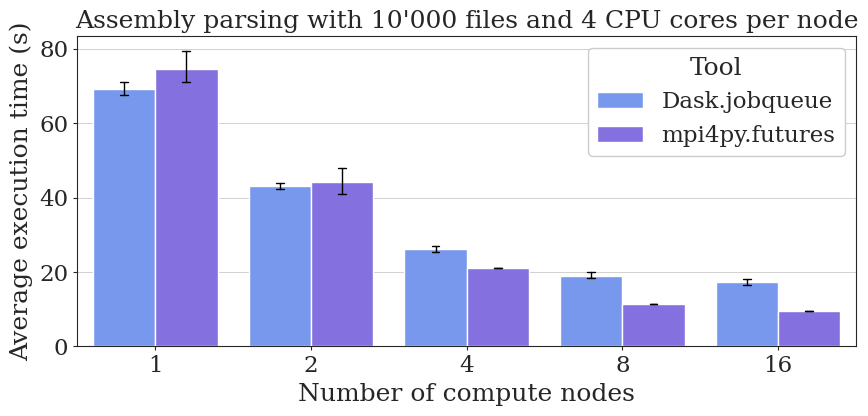

In [92]:
# plots are procuded in loops

y_axis_text = 'Average execution time (s)'

plot_loop = {
    'dask_mpi_nodes_4' : {
        'on_hue' : 'tool',
        'on_hue_label' : 'Tool',
        'on_y' : 'time (s)',
        'on_y_label' : y_axis_text,
        'on_x' : 'nodes',
        'on_x_label' : 'Number of compute nodes',
        'columns' : ['nodes', 'tool', 'repetition'],
        'filter_cols' : [
            ('tool', ['dask','mpi']),
            ('cores_per_node', [4]),
            ('nodes', [1,2,4,8,16]),
            ('n_targets', [10000])
        ],
        'title' : "Assembly parsing with 10'000 files and 4 CPU cores per node",
        'loc' : 'upper right',
        'ncol' : 1,
        'annotate' : False
    }     
}

for k,v in plot_loop.items():
    df = combined_df.copy()
    # what we want to display
    on_x = v.get('on_x')
    on_x_label = v.get('on_x_label')
    on_y = v.get('on_y')
    on_y_label= v.get('on_y_label')
    on_hue = v.get('on_hue')
    on_hue_label = v.get('on_hue_label')

    # columns
    columns = v.get('columns')

    ##### Change this and the name to make and save another plot
    filter_cols = v.get('filter_cols') 
    # name of the plot
    title = v.get('title')
    plot_name = '{}'.format(k)
    
    # to annotate bars
    annotate=v.get('annotate', False)
    # ignored if annotate=False
    annotation_rotated=True

    # Filter data
    for filt in filter_cols:
        if filt[1] is None:
            df = df[(df[filt[0]].isnull())]
        else:
            df = df[(df[filt[0]].isin(filt[1]))]
    
    # Sum time over steps
    data = df.groupby(columns)['time (s)'].sum().reset_index()
    
    # rename methods column
    if 'tool' in data.columns:
        data['tool'] = data['tool'].replace('dask', 'Dask.jobqueue')
        data['tool'] = data['tool'].replace('mpi', 'mpi4py.futures')
    
    # Plot the bar plot using seaborn
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(
        data=data,
        x=on_x,
        y=on_y,
        hue=on_hue,
        estimator=np.mean, 
        errorbar = lambda x: (x.min(), x.max()), 
        palette=custom_palette[:data[on_hue].nunique()],
        capsize=0.1,  # Controls the size of the caps on the error bars
        err_kws={'color': 'black', 'linewidth': 1} # Width of the error bars   
    )

    # Set plot properties
    plt.xlabel(on_x_label)
    plt.ylabel(on_y_label)

    # Add thin grid lines at y-axis ticks
    make_grid(ax, plt)

    # Set the title using plt.title()
    plt.title(title)

    # Place the legend at the top-right corner
    leg = plt.legend(title=on_hue_label, loc=v.get('loc'), ncol=v.get('ncol'))
    leg.get_frame().set_alpha(1) 

    # Format the y-axis ticks with a space as a thousand separator
    # Format legend labels with a space as a thousand separator
    formatter(ax)

    # Annotate each bar with the formatted value
    if annotate:
        annotater(ax, plt, annotation_rotated)

    # finish, save and plot
    finisher(plot_name, plt)


### GCsnap2.0 Cluster
<a id='gc2c'></a>

In [93]:
# path to files for unimproved GCsanp2
path_csv = '/users/stud/k/kruret00/PASC25/experiments_deliver/setA/'
    
# all csv files
all_files = glob.glob(os.path.join(path_csv,'results', '**', 'timing.csv'))

# add distributed experiments
path_csv = '/users/stud/k/kruret00/PASC25/experiments_deliver/setB/'
    
# all csv files
all_files = glob.glob(os.path.join(path_csv,'results', '**','timing.csv')) + all_files


# Read all CSV files and combine them into a single DataFrame
df_list = []
for filename in all_files:
    
    folder_name = os.path.basename(os.path.split(filename)[0])
    n_targets = int(folder_name.split('_')[0])
    n_nodes = int(folder_name.split('_')[2])
    n_processes = int(folder_name.split('_')[4])
    n_cores = int(folder_name.split('_')[6])
    n_rep = int(folder_name.split('_')[8])
    
    # column names
    col_names=['task',
           'total time (s)']
    
    # read the csv
    df = pd.read_csv(filename, index_col=None, header=0, sep=',', names=col_names)
    
    # convert to float (as seconds) and int (count)
    df['total time (s)'] = df['total time (s)'].astype(float)
    
    # add targets and threads colum
    df['targets'] = n_targets
    df['nodes'] = n_nodes
    df['ranks'] = n_processes
    df['cores'] = n_cores
    df['repetition'] = n_rep


    # add variant of results
    if filename.split('/')[-4] == 'setA':
        df['variant'] = 'GCsnap2 Cluster (A.)'
    elif filename.split('/')[-4] == 'setB':
        df['variant'] = 'Improved Taxonomy (B.)'
        
    df_list.append(df)

    
combined_df = pd.concat(df_list, axis=0, ignore_index=True)
df_gc2 = combined_df.copy()

filter_l = ['End-to-end','Step 1:\nCollect','Step 2:\nFind families','Step 3:\nAnnotate','Producing output']

# combine results to blocks
steps = ['All steps 0-10',
         'Step 0: Parse Targets',
         'Step 1: Collecting the genomic contexts',
         'Step 1a: Mapping',
         'Step 1b: Assemblies',
         'Step 1c: Sequences',
         'Step 2: Finding protein families',
         'Step 3: Annotating functions and structures',
         'Step 4-5: Finding operon/genomic_context',
         'Step 6: Mapping taxonomy',
         'Step 7: Finding ALL proteins with transmembrane segments',
         'Step 8-9: Producing figures',
         'Step 10: Write output']
df_gc2 = df_gc2[df_gc2['task'].isin(steps)].copy()
df_gc2_steps = df_gc2.copy()
df_gc2['task'] = df_gc2['task'].replace(steps[0], 'End-to-end')
df_gc2['task'] = df_gc2['task'].replace(steps[2], 'Step 1:\nCollect')
df_gc2['task'] = df_gc2['task'].replace(steps[6], 'Step 2:\nFind families')
df_gc2['task'] = df_gc2['task'].replace(steps[7:11], 'Step 3:\nAnnotate')
df_gc2['task'] = df_gc2['task'].replace(steps[11:], 'Producing output')
df_gc2 = df_gc2[df_gc2['task'].isin(filter_l)].copy()
block_df_gc2 = df_gc2.groupby(['task', 'targets', 'nodes', 'ranks', 'cores', 'repetition','variant'])['total time (s)'].sum().reset_index()
bs_df_gc2 = pd.concat([block_df_gc2,df_gc2_steps], axis=0, ignore_index=True).copy()
bs_df_gc2[(bs_df_gc2['task'] == 'End-to-end') & (bs_df_gc2['ranks'] == 4) & (bs_df_gc2['nodes'].isin([4])) & (bs_df_gc2['cores'] == 4) & (bs_df_gc2['variant'] == 'Improved Taxonomy (B.)')]['total time (s)'].sum() / 5

92.88545751571655

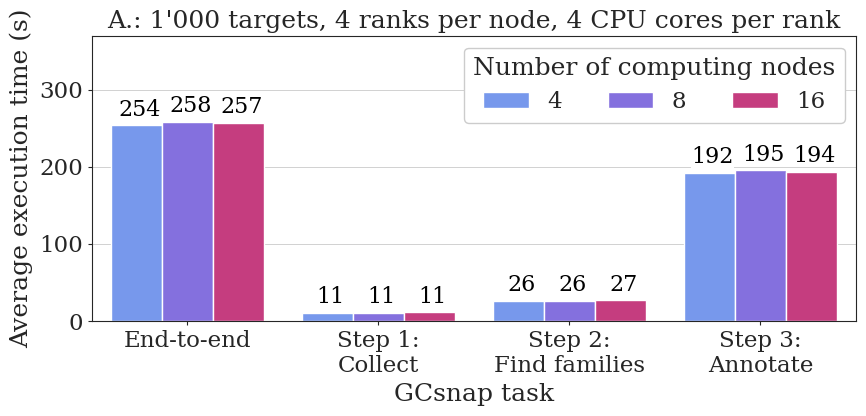

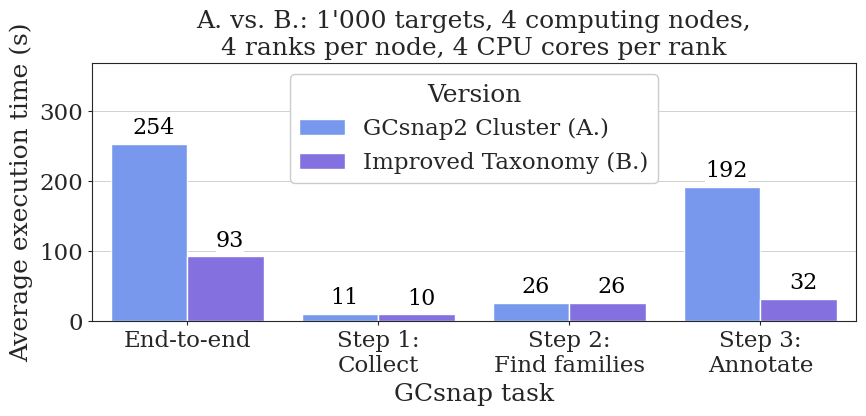

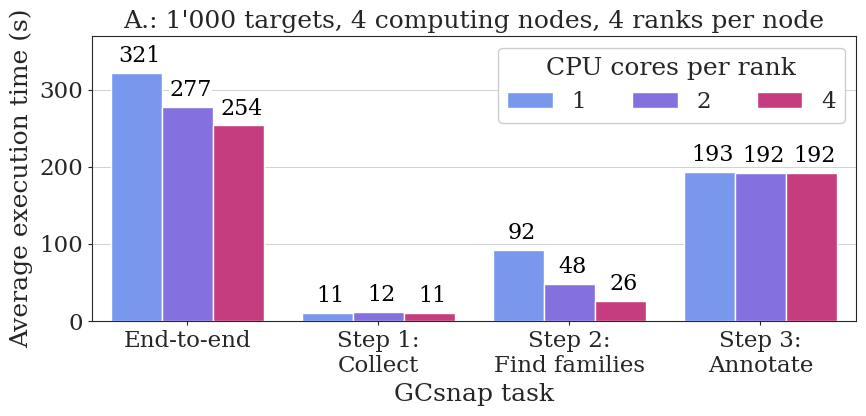

In [94]:
# plots are procuded in loops

y_axis_text = 'Average execution time (s)'
         
# possible steps:
steps = ['All steps 0-10', 
         'Step 0: Parse Targets',
         'Step 1: Collecting the genomic contexts',
         'Step 1a: Mapping',
         'Step 1b: Assemblies',
         'Step 1c: Sequences',
         'Step 2: Finding protein families',
         'Step 3: Annotating functions and structures',
         'Step 4-5: Finding operon/genomic_context',
         'Step 6: Mapping taxonomy',
         'Step 7: Finding ALL proteins with transmembrane segments',
         'Step 8-9: Producing figures',
         'Step 10: Write output']

plot_loop = {
    'gcsnap2_steps' : {
        'on_x' : 'task',
        'on_x_label' : 'GCsnap task',
        'on_y' : 'total time (s)',
        'on_y_label' : y_axis_text,
        'on_hue' : 'nodes',
        'on_hue_label' : 'Number of computing nodes',
        'columns' : ['task', 'nodes', 'repetition'],
        'filter_cols' : [
            ('task', ['End-to-end','Step 1:\nCollect','Step 2:\nFind families','Step 3:\nAnnotate']),
            ('variant', ['GCsnap2 Cluster (A.)']),
            ('nodes', [4, 8, 16]),
            ('ranks', [4]),
            ('cores', [4]),
            ('targets', [1000])
        ],
        'x_order' : 'task',
        'hue_order' : 'nodes',
        'title' : "A.: 1'000 targets, 4 ranks per node, 4 CPU cores per rank",
        'loc' : 'upper right',
        'ncol' : 3,
        'annotate' : True,
        'steps_of_interest' : False,
        'ylim': [0,369]
    },    
    'gcsnap2_improvement' : {
            'on_x' : 'task',
            'on_x_label' : 'GCsnap task',
            'on_y' : 'total time (s)',
            'on_y_label' : y_axis_text,
            'on_hue' : 'variant',
            'on_hue_label' : 'Version',
            'columns' : ['task', 'variant', 'repetition'],
            'filter_cols' : [
                ('task', ['End-to-end','Step 1:\nCollect','Step 2:\nFind families','Step 3:\nAnnotate']),
                ('variant', ['GCsnap2 Cluster (A.)','Improved Taxonomy (B.)']),                
                ('nodes', [4]),
                ('ranks', [4]),
                ('cores', [4]),
                ('targets', [1000])
            ],
            'x_order' : 'task',
            'hue_order' : 'variant',
            'title' : "A. vs. B.: 1'000 targets, 4 computing nodes,\n4 ranks per node, 4 CPU cores per rank",
            'loc' : 'upper center',
            'ncol' : 1,
            'annotate' : True,
            'steps_of_interest' : False,
            'ylim': [0,369]
        },    
    'gcsnap2_cpu' : {
            'on_x' : 'task',
            'on_x_label' : 'GCsnap task',
            'on_y' : 'total time (s)',
            'on_y_label' : y_axis_text,
            'on_hue' : 'cores',
            'on_hue_label' : 'CPU cores per rank',
            'columns' : ['task', 'cores', 'repetition'],
            'filter_cols' : [
                ('task', ['End-to-end','Step 1:\nCollect','Step 2:\nFind families','Step 3:\nAnnotate']),
                ('variant', ['GCsnap2 Cluster (A.)']),                
                ('nodes', [4]),
                ('ranks', [4]),
                ('cores', [1,2,4]),
                ('targets', [1000])
            ],
            'x_order' : 'task',
            'hue_order' : 'cores',
            'title' : "A.: 1'000 targets, 4 computing nodes, 4 ranks per node",
            'loc' : 'upper right',
            'ncol' : 3,
            'annotate' : True,
            'steps_of_interest' : False,
            'ylim': [0,369]
        },           
}

for k,v in plot_loop.items():
    df = bs_df_gc2.copy()
    # what we want to display
    on_x = v.get('on_x')
    on_x_label = v.get('on_x_label')
    on_y = v.get('on_y')
    on_y_label= v.get('on_y_label')
    on_hue = v.get('on_hue')
    on_hue_label = v.get('on_hue_label')

    # columns
    columns = v.get('columns')

    ##### Change this and the name to make and save another plot
    filter_cols = v.get('filter_cols') 
    # name of the plot
    title = v.get('title')
    plot_name = '{}'.format(k)

        # to annotate bars
    annotate=v.get('annotate', False)
    # ignored if annotate=False
    annotation_rotated=False

    # Filter data
    for filt in filter_cols:
        if filt[1] is None:
            df = df[(df[filt[0]].isnull())]
        else:
            df = df[(df[filt[0]].isin(filt[1]))]
            
    # search order as defined in plot loop
    tuple_ = next((item for item in v.get('filter_cols') if item[0] == v.get('x_order')), None)
    x_order = tuple_[1]
    tuple_ = next((item for item in v.get('filter_cols') if item[0] == v.get('hue_order')), None)
    hue_order = tuple_[1]
    
    # Sum time over steps
    data = df.groupby(columns)['total time (s)'].sum().reset_index()
    
    # Plot the bar plot using seaborn
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(
        data=data,
        x=on_x,
        order = x_order,
        y=on_y,
        hue=on_hue,     
        hue_order=hue_order, 
        estimator=np.mean, 
        errorbar = None, 
        palette=custom_palette[:data[on_hue].nunique()],
        capsize=0.1,  # Controls the size of the caps on the error bars
        err_kws={'color': 'black', 'linewidth': 1} # Width of the error bars   
    )

    # Set plot properties
    plt.xlabel(on_x_label)
    plt.ylabel(on_y_label)

    # Add thin grid lines at y-axis ticks
    make_grid(ax, plt)

    # Set the title using plt.title()
    plt.title(title)
    
    # set y axis limits for plot to fit
    if not v.get('ylim',None) is None:
        l,u = v.get('ylim')
        plt.ylim(l,u)

    # Place the legend at the top-right corner
    leg = plt.legend(title=on_hue_label, loc=v.get('loc'), ncol=v.get('ncol'))
    leg.get_frame().set_alpha(1) 
    leg.get_frame().set_alpha(1) 

    # Format the y-axis ticks with a space as a thousand separator
    # Format legend labels with a space as a thousand separator
    formatter(ax)

    # Annotate each bar with the formatted value
    if annotate:
        annotater(ax, plt, annotation_rotated)

    # finish, save and plot
    finisher(plot_name, plt)

### Portability of GCsnap
<a id='scaling'></a>

In [28]:
# path to files for unimproved GCsanp2
path_csv = '/users/stud/k/kruret00/PASC25/experiments_deliver/setC/'
    
# all csv files
all_files = glob.glob(os.path.join(path_csv,'results', '**', 'timing.csv'))

# Read all CSV files and combine them into a single DataFrame
df_list = []
for filename in all_files:
    
    folder_name = os.path.basename(os.path.split(filename)[0])
    n_targets = int(folder_name.split('_')[0])
    n_nodes = int(folder_name.split('_')[2])
    n_processes = int(folder_name.split('_')[4])
    n_cores = int(folder_name.split('_')[6])
    n_rep = int(folder_name.split('_')[8])
    
    # column names
    col_names=['task',
           'total time (s)']
    
    # read the csv
    df = pd.read_csv(filename, index_col=None, header=0, sep=',', names=col_names)
    
    # convert to float (as seconds) and int (count)
    df['total time (s)'] = df['total time (s)'].astype(float)
    
    # add targets and threads colum
    df['targets'] = n_targets
    df['nodes'] = n_nodes
    df['ranks'] = n_processes
    df['cores'] = n_cores
    df['repetition'] = n_rep
    df['total_ranks'] = str(n_processes) + '×' + str(n_cores)
        
    df_list.append(df)
    
combined_df = pd.concat(df_list, axis=0, ignore_index=True)
df_gc2 = combined_df.copy()

filter_l = ['End-to-end','Parse Assemblies','Find Families','Find Operons','Produce Output','Other Substeps']

# combine results to blocks
steps = ['All steps 0-10',
         'Step 0: Parse Targets',
         'Step 1: Collecting the genomic contexts',
         'Step 1a: Mapping',
         'Step 1b: Assemblies',
         'Step 1c: Sequences',
         'Step 2: Finding protein families',
         'Step 3: Annotating functions and structures',
         'Step 4-5: Finding operon/genomic_context',
         'Step 6: Mapping taxonomy',
         'Step 7: Finding ALL proteins with transmembrane segments',
         'Step 8-9: Producing figures',
         'Step 10: Write output']
df_gc2 = df_gc2[df_gc2['task'].isin(steps)].copy()
df_gc2_steps = df_gc2.copy()
df_gc2['task'] = df_gc2['task'].replace(steps[0], 'End-to-end')
df_gc2['task'] = df_gc2['task'].replace(steps[4], 'Parse Assemblies')
df_gc2['task'] = df_gc2['task'].replace(steps[6], 'Find Families')
df_gc2['task'] = df_gc2['task'].replace(steps[7], 'Other Substeps')
df_gc2['task'] = df_gc2['task'].replace(steps[8], 'Find Operons')
df_gc2['task'] = df_gc2['task'].replace(steps[1], 'Other Substeps')
df_gc2['task'] = df_gc2['task'].replace(steps[3], 'Other Substeps')
df_gc2['task'] = df_gc2['task'].replace(steps[5], 'Other Substeps')
df_gc2['task'] = df_gc2['task'].replace(steps[9:11], 'Other Substeps')
df_gc2['task'] = df_gc2['task'].replace(steps[11:], 'Produce Output')
df_gc2 = df_gc2[df_gc2['task'].isin(filter_l)].copy()
block_df_gc2 = df_gc2.groupby(['task', 'targets', 'nodes', 'total_ranks' , 'ranks', 'cores', 'repetition'])['total time (s)'].sum().reset_index()
bs_df_gc2 = pd.concat([block_df_gc2,df_gc2_steps], axis=0, ignore_index=True).copy()
bs_df_gc2.head(10)

,task,targets,nodes,total_ranks,ranks,cores,repetition,total time (s)
0,End-to-end,10000,1,4×16,4,16,1,754.938236
1,End-to-end,10000,1,4×16,4,16,2,764.549574
2,End-to-end,10000,1,4×16,4,16,3,760.739531
3,End-to-end,10000,1,4×16,4,16,4,751.040657
4,End-to-end,10000,1,4×16,4,16,5,753.407128
5,End-to-end,10000,1,4×32,4,32,1,729.063092
6,End-to-end,10000,1,4×32,4,32,2,735.651354
7,End-to-end,10000,1,4×32,4,32,3,733.315089
8,End-to-end,10000,1,4×32,4,32,4,741.802011
9,End-to-end,10000,1,4×32,4,32,5,741.745446


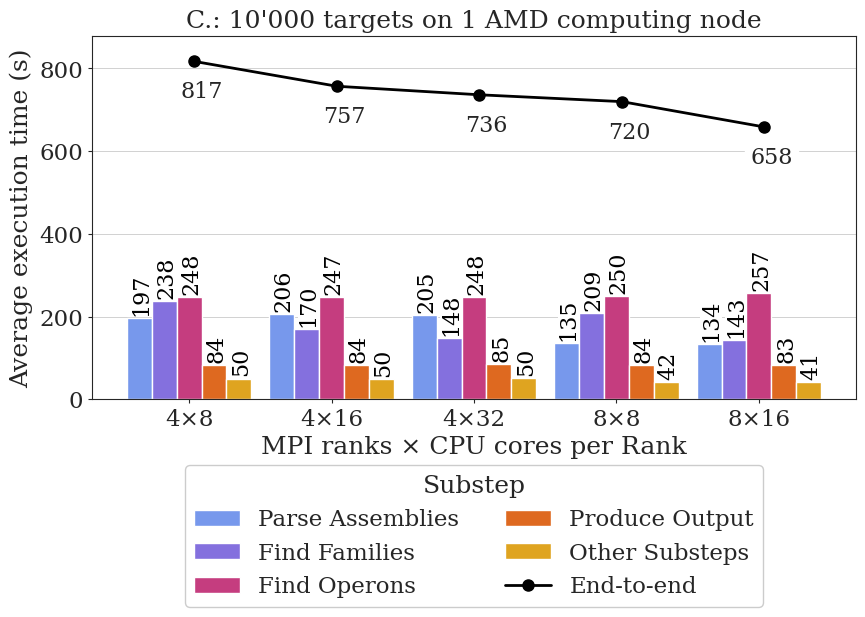

In [ ]:
# plots are procuded in loops

y_axis_text = 'Average execution time (s)'
         
# possible steps:
steps = ['All steps 0-10', 
         'Step 0: Parse Targets',
         'Step 1: Collecting the genomic contexts',
         'Step 1a: Mapping',
         'Step 1b: Assemblies',
         'Step 1c: Sequences',
         'Step 2: Finding protein families',
         'Step 3: Annotating functions and structures',
         'Step 4-5: Finding operon/genomic_context',
         'Step 6: Mapping taxonomy',
         'Step 7: Finding ALL proteins with transmembrane segments',
         'Step 8-9: Producing figures',
         'Step 10: Write output']

plot_loop = {
    'gcsnap2_portability' : {
        'on_x' : 'total_ranks',
        'on_x_label' : 'MPI ranks × CPU cores per Rank',
        'on_y' : 'total time (s)',
        'on_y_label' : y_axis_text,
        'on_hue' : 'task',
        'on_hue_label' : 'Substep',
        'columns' : ['task', 'total_ranks', 'repetition'],
        'filter_cols' : [
            ('task', ['Parse Assemblies','Find Families','Find Operons','Produce Output','Other Substeps','End-to-end',]),
            ('total_ranks', ['4×8','4×16','4×32','8×8','8×16']),
            ('targets', [10000])
        ],
        'x_order' : 'total_ranks',
        'hue_order' : 'task',
        'title' : "C.: 10'000 targets on 1 AMD computing node",
        'loc' : 'upper center',
        'ncol' : 2,
        'annotate' : True,
        'steps_of_interest' : False,
        'ylim': [0,879]
    }
}

for k,v in plot_loop.items():
    df = bs_df_gc2.copy()
    # what we want to display
    on_x = v.get('on_x')
    on_x_label = v.get('on_x_label')
    on_y = v.get('on_y')
    on_y_label= v.get('on_y_label')
    on_hue = v.get('on_hue')
    on_hue_label = v.get('on_hue_label')

    # columns
    columns = v.get('columns')

    ##### Change this and the name to make and save another plot
    filter_cols = v.get('filter_cols') 
    # name of the plot
    title = v.get('title')
    plot_name = '{}'.format(k)

        # to annotate bars
    annotate=v.get('annotate', False)

    if not annotate:
        errorbar = lambda x: (x.min(), x.max())
    else:
        errorbar = None
    # ignored if annotate=False
    annotation_rotated=True

    # Filter data
    for filt in filter_cols:
        if filt[1] is None:
            df = df[(df[filt[0]].isnull())]
        else:
            df = df[(df[filt[0]].isin(filt[1]))]
            
    # search order as defined in plot loop
    tuple_ = next((item for item in v.get('filter_cols') if item[0] == v.get('x_order')), None)
    x_order = tuple_[1]
    tuple_ = next((item for item in v.get('filter_cols') if item[0] == v.get('hue_order')), None)
    hue_order = tuple_[1]
    
    # Sum time over steps
    data = df.groupby(columns)['total time (s)'].sum().reset_index()

    # Separate "End-to-end" data from the rest
    df_end_to_end = data[data[on_hue] == "End-to-end"].copy()
    df_bars = data[data[on_hue] != "End-to-end"].copy()

    # Convert categorical x-axis labels into numeric positions
    x_positions = np.arange(len(x_order))  # Numeric indices for bars   
    
    # Plot the bar plot using seaborn
    plt.figure(figsize=(fig_width, fig_height*1.5))
    ax = sns.barplot(
        data=df_bars,
        x=on_x,
        order = x_order,
        y=on_y,
        hue=on_hue,     
        hue_order=hue_order, 
        width=1.05,
        estimator=np.mean, 
        errorbar = errorbar, 
        palette=custom_palette[:data[on_hue].nunique()],
        capsize=0.1,  # Controls the size of the caps on the error bars
        err_kws={'color': 'black', 'linewidth': 1} # Width of the error bars   
    )

    # Get bar centers from Seaborn's categorical plot layout
    bar_centers = []
    for bar in ax.containers:
        for p in bar:
            bar_centers.append(p.get_x() + p.get_width() * 5 / 2)

    # Extract only unique x positions (since bars are grouped by hue)
    xticks_positions = sorted(set(bar_centers[:len(x_order)]))

    # Set x-ticks exactly at bar centers
    ax.set_xticks(xticks_positions)
    ax.set_xticklabels(x_order)  # Use the actual category labels

    # Plot "End-to-end" as a **connected line plot**
    if not df_end_to_end.empty:
        # Compute mean execution time for "End-to-end"
        line_y = [df_end_to_end[df_end_to_end[on_x] == x][on_y].mean() for x in x_order]

        # Plot the line
        plt.plot(x_positions-0.05, line_y, color='black', marker='o', markersize=8, linewidth=2, label='End-to-end')

        # Annotate points with execution time
        for i, (x, y) in enumerate(zip(x_positions, line_y)):
            plt.text(i, y - 100, f"{y:.0f}", ha='center', va='bottom', fontsize=font_size,
                    bbox=dict(facecolor='white', edgecolor='white'))


    # Set plot properties
    plt.xlabel(on_x_label)
    plt.ylabel(on_y_label)

    # Add thin grid lines at y-axis ticks
    make_grid(ax, plt)

    # Set the title using plt.title()
    plt.title(title)
    
    # set y axis limits for plot to fit
    if not v.get('ylim',None) is None:
        l,u = v.get('ylim')
        plt.ylim(l,u)

    # Get existing legend handles and labels
    handles, labels = ax.get_legend_handles_labels()

    # Filter out 'End-to-end' from the legend
    filtered_handles = [h for h, l in zip(handles, labels) if l != 'End-to-end']
    filtered_labels = [l for l in labels if l != 'End-to-end']

    # Manually create a legend entry for 'End-to-end' as a line
    line_legend = mlines.Line2D([], [], color='black', marker='o', markersize=8, linewidth=2, label='End-to-end')

    # Add it to the legend
    filtered_handles.append(line_legend)
    filtered_labels.append('End-to-end')

    # Move legend **below the plot**
    leg = plt.legend(filtered_handles, filtered_labels, title=on_hue_label ,loc='upper center', bbox_to_anchor=(0.5, -0.15),
                    ncol=2, frameon=True)

    # Ensure the legend has a visible border
    leg.get_frame().set_alpha(1)

    # Format the y-axis ticks with a space as a thousand separator
    # Format legend labels with a space as a thousand separator
    formatter(ax)

    # Annotate each bar with the formatted value
    if annotate:
        annotater(ax, plt, annotation_rotated)

    # finish, save and plot
    finisher(plot_name, plt)

### MPI profiling
<a id='mpiprofiling'></a>

Code to create the MPI profiling plot  

In [5]:
# fixed values from experiment
n_targets = 10000
n_nodes = 1
n_processes = 8
n_cores = 8

# path to files for unimproved GCsanp2
path_log = '/users/stud/k/kruret00/PASC25/experiments_deliver/MPIprofiling/'
    
# all csv files
all_files = glob.glob(os.path.join(path_log,'rank_rep_?', '*.log'))

df_list = []
 
for file in all_files:
    # os.path.split() splits file from pat
    folder_name = os.path.basename(os.path.split(file)[0])
    file_name = os.path.basename(os.path.split(file)[1])

    # get repetiton and parallel function executed
    n_rep = int(folder_name.split('_')[2])
    n_func = file_name.split('-')[1]

    # Define a regex pattern to extract relevant fields
    log_pattern = re.compile(
        r'(?P<Timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{6}), '  # Accept 6-digit microseconds
        r'Func: (?P<Function>\w+), '
        r'Len: (?P<Len>\d+), '
        r'Workers: (?P<Workers>\d+), '
        r'Rank: (?P<Rank>\d+), '
        r'PID: (?P<PID>\d+), '
        r'Num Args: (?P<NumArgs>\d+), '
        r'Type Args: \[.*?\], '  # Ignore Type Args
        r'Size Args: \[.*?\], '  # Ignore Size Args
        r'Start: (?P<Start>[\d\- :,.]+), '  # Allow microsecond precision
        r'End: (?P<End>[\d\- :,.]+), '  # Allow microsecond precision
        r'Duration: (?P<Duration>[\d.]+)'
    )

    data = []
    # Read each log file and extract information
    with open(file, 'r') as f:
        for line in f:
            match = log_pattern.search(line)
            if match:
                data.append(match.groupdict())         

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Convert data types
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors="coerce")
    df['Start'] = pd.to_datetime(df['Start'], errors="coerce")
    df['End'] = pd.to_datetime(df['End'], errors="coerce")
    df['Duration'] = df['Duration'].astype(float)
    df['Len'] = df['Len'].astype(int)
    df['Workers'] = df['Workers'].astype(int)
    df['Rank'] = df['Rank'].astype(int)
    df['PID'] = df['PID'].astype(int)
    df['NumArgs'] = df['NumArgs'].astype(int)  

    # add fixed values
    df['Nodes'] = n_nodes
    df['Ranks'] = n_processes
    df['Cores'] = n_cores
    df['Targets'] = n_targets
    df['Repetition'] = n_rep
        
    # append to dataframe list
    df_list.append(df)
    
combined_df = pd.concat(df_list, axis=0, ignore_index=True)
df = combined_df.copy()

print(df['Function'].unique())

# rename the functions
df['Function'] = df['Function'].replace('adapt_families', 'Find Families')
df['Function'] = df['Function'].replace('assign_families', 'Find Families')
df['Function'] = df['Function'].replace('do_mapping', 'Mapping')
df['Function'] = df['Function'].replace('run_each_assemblies', 'Parse Assemblies')
df['Function'] = df['Function'].replace('run_each_sequences', 'Sequences')
df['Function'] = df['Function'].replace('run_each_famfunct', 'Annotate Functions')
df['Function'] = df['Function'].replace('do_mapping_fam', 'Annotate Functions')
df['Function'] = df['Function'].replace('run_each_taxonomy', 'Taxonomies')

# rename function column
df.rename(columns={'Function': 'Substep'}, inplace=True)
df_prof = df.copy()

print(df['Timestamp'].min(),df['Start'].min(), df['End'].max())
df_prof[df_prof['Substep'] == 'Parse Assemblies'][['Rank','Duration','Repetition']]



['adapt_families' 'assign_families' 'do_mapping' 'do_mapping_fam'
 'run_each_assemblies' 'run_each_famfunct' 'run_each_sequences'
 'run_each_taxonomy']
2025-03-10 09:11:00.829698 2025-03-10 09:11:00.829718 2025-03-10 10:11:19.165035


,Rank,Duration,Repetition
110,1,24.272036,1
111,2,103.422876,1
112,3,149.991008,1
113,4,46.843343,1
114,5,37.842505,1
115,6,25.373110,1
116,7,46.675179,1
248,1,143.845651,2
249,2,48.112444,2
250,3,37.504954,2


In [6]:

# now add the information of the coordinator
keep = [
        'GCsnap started', 
        'Mapping ',
        'Download assemblies and extract flanking genes',
        'Add sequences, tax id and species name to flanking genes',
        'Prepare data for MMseqs',
        'Functional annotation needs mapping first',
        'Running standard operon clustering',
        'Done Selected operon written to selected_operons.json',
        'Creating genomic context figures',
        'Done Syntenies information written to all_syntenies.json'
]

task_mapping = {
    'GCsnap started': 'Startup',
    'Mapping ': 'Mapping',
    'Download assemblies and extract flanking genes': 'Parse Assemblies',
    'Add sequences, tax id and species name to flanking genes': 'Sequences',
    'Prepare data for MMseqs': 'Find Families',
    'Functional annotation needs mapping first': 'Annotate Functions',
    'Running standard operon clustering': 'Find Operons',
    'Done Selected operon written to selected_operons.json': 'Taxonomies',
    'Creating genomic context figures': 'Produce Output',
    'Done Syntenies information written to all_syntenies.json': 'End'
}

# all csv files
all_files = glob.glob(os.path.join(path_log,'results','**', 'gcsnap*.log'))

df_list = []
for file in all_files:
    file_name = os.path.basename(os.path.split(file)[1])
    n_rep = file_name.split('_')[-1].split('.')[0]

    # Define a regex pattern to extract relevant fields
    log_pattern = re.compile(r'(?P<Timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) - .*? - INFO - (?P<Substep>.*)')

    # Read and parse the log file
    coordinator_data = []
    with open(file, 'r') as f:
        for line in f:
            match = log_pattern.search(line)
            if match:
                coordinator_data.append(match.groupdict())    

    # Convert to DataFrame
    df_coord = pd.DataFrame(coordinator_data) 

    # Convert timestamp to datetime
    df_coord['Timestamp'] = pd.to_datetime(df_coord['Timestamp'], format="%Y-%m-%d %H:%M:%S,%f")

    # Keep only relevant tasks
    df_coord = df_coord[df_coord['Substep'].isin(keep)].copy()

    # Map generic task names for better visualization
    df_coord['Substep'] = df_coord['Substep'].replace(task_mapping)

    # Define Rank 0 for coordinator execution
    df_coord['Rank'] = 0
    df_coord['Start'] = df_coord['Timestamp']

    # SEt end time as start time of next
    df_coord['End'] = df_coord['Start'].shift(-1)
    # the end is NaN, remove it
    df_coord = df_coord.dropna()

    # Select only relevant columns
    df_coord = df_coord[['Rank', 'Substep', 'Start', 'End']]

    # add fixed values
    df_coord['Nodes'] = n_nodes
    df_coord['Ranks'] = n_processes
    df_coord['Cores'] = n_cores
    df_coord['Targets'] = n_targets
    df_coord['Repetition'] = n_rep

    # append to dataframe list
    df_list.append(df_coord)
    
combined_df = pd.concat(df_list, axis=0, ignore_index=True)
df_coord = combined_df.copy()

df_coord['Substep'].unique()
combined_df


,Rank,Substep,Start,End,Nodes,Ranks,Cores,Targets,Repetition
0,0,Startup,2025-03-10 09:10:58.035,2025-03-10 09:10:58.910,1,8,8,10000,1
1,0,Mapping,2025-03-10 09:10:58.910,2025-03-10 09:11:01.665,1,8,8,10000,1
2,0,Parse Assemblies,2025-03-10 09:11:01.665,2025-03-10 09:13:31.720,1,8,8,10000,1
3,0,Sequences,2025-03-10 09:13:31.720,2025-03-10 09:13:36.910,1,8,8,10000,1
4,0,Find Families,2025-03-10 09:13:36.910,2025-03-10 09:17:04.417,1,8,8,10000,1
5,0,Annotate Functions,2025-03-10 09:17:04.417,2025-03-10 09:17:14.954,1,8,8,10000,1
6,0,Find Operons,2025-03-10 09:17:14.954,2025-03-10 09:21:26.982,1,8,8,10000,1
7,0,Taxonomies,2025-03-10 09:21:26.982,2025-03-10 09:21:50.589,1,8,8,10000,1
8,0,Produce Output,2025-03-10 09:21:50.589,2025-03-10 09:23:14.634,1,8,8,10000,1
9,0,Startup,2025-03-10 09:23:30.013,2025-03-10 09:23:30.723,1,8,8,10000,2


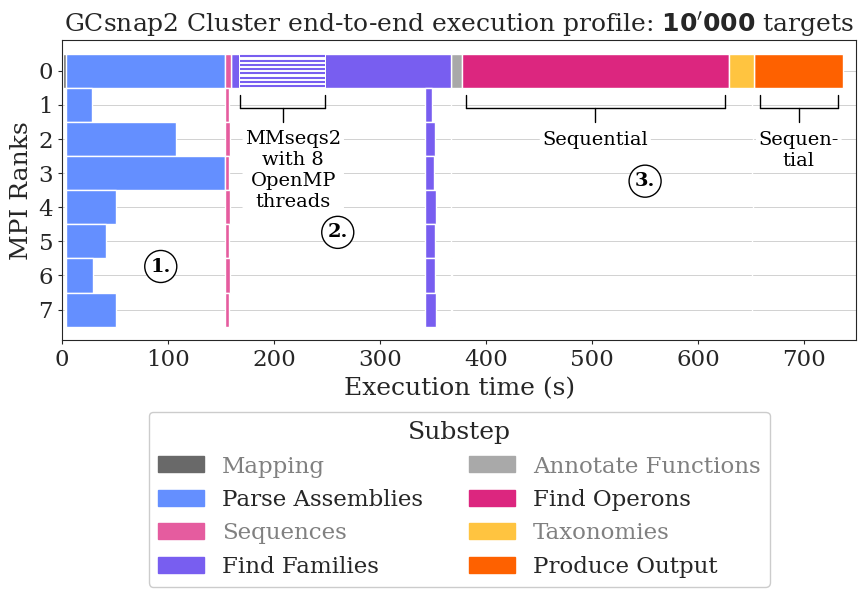

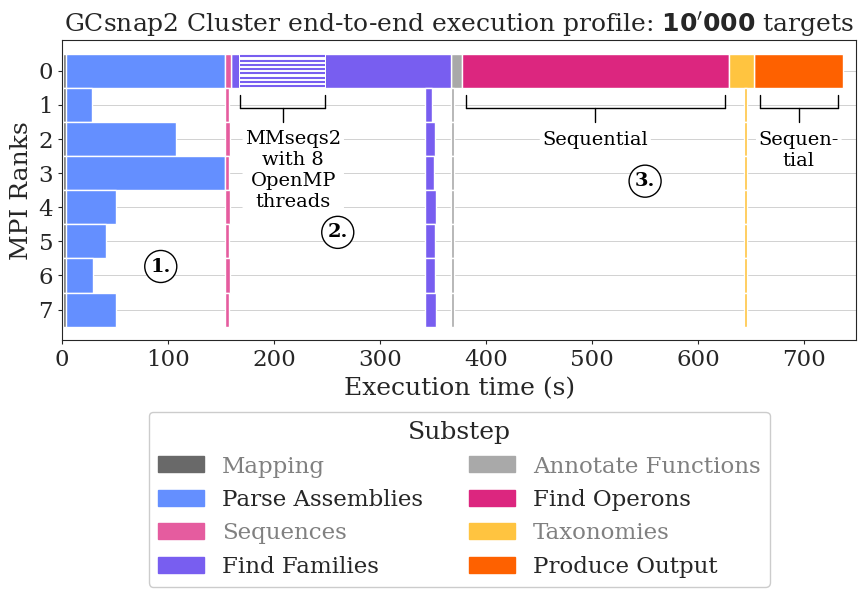

In [7]:
# do the plot twice, one with adjusted values and one without

for adjusted in range(2):
    # the plot
    cols = ['Rank', 'Substep', 'Start', 'End', 'Nodes', 'Ranks', 'Cores', 'Targets', 'Repetition']

    # Define function order (substeps)
    function_order = [
        'Startup',
        'Mapping',
        'Parse Assemblies',
        'Sequences',
        'Find Families',
        'Annotate Functions',
        'Find Operons',
        'Taxonomies',
        'Produce Output'
    ]

    contain_col = ['Mapping', 'Parse Assemblies', 'Sequences', 'Find Families', 'Annotate Functions', 'Find Operons', 'Taxonomies', 'Produce Output']

    # Filter relevant substeps
    df_filtered = df_prof[df_prof['Substep'].isin(function_order)].copy()

    # add rank 0
    df_filtered = pd.concat([df_filtered[cols], df_coord[cols]], axis=0, ignore_index=True).copy()

    # Ensure timestamps are in datetime format
    df_filtered['Start'] = pd.to_datetime(df_filtered['Start'])
    df_filtered['End'] = pd.to_datetime(df_filtered['End'])
    df_filtered["Repetition"] = df_filtered["Repetition"].astype(int)  # Convert all to integer

    # List to store processed repetitions
    aligned_repetitions = []
    # only take repetition 1
    for rep in df_filtered['Repetition'].unique()[:1]:
        # Extract repetition-specific data
        df_rep = df_filtered[df_filtered['Repetition'] == rep].copy()

        # compute the elapsed time as end - start for all rows
        df_rep['Elapsed'] = (df_rep['End'] - df_rep['Start']).dt.total_seconds()

        # find the start up time of rank 0 for the function Startup
        start_time = df_rep[(df_rep['Rank'] == 0) & (df_rep['Substep'] == 'Startup')]['Start'].values[0]

        # compute all start times relative to the start time of rank 0
        df_rep['Start'] = (df_rep['Start'] - start_time).dt.total_seconds()    

        # Store processed repetition
        aligned_repetitions.append(df_rep)

    # Combine all processed repetitions
    df_aligned = pd.concat(aligned_repetitions, ignore_index=True)

    df_aligned = df_aligned[df_aligned['Substep'].isin(contain_col)].copy()

    #print(df_aligned[df_aligned['Substep'] == 'Parse Assemblies'])

    # Aggregate: Take the mean elapsed time per (Rank, Substep)
    df_avg = df_aligned.groupby(['Rank', 'Substep']).agg({
        'Start': 'min',  # Use min for start times
        'Elapsed': 'mean'  # Use mean for elapsed times
    }).reset_index()

    # some of the MPI ranks are this fast, that they are not visible on the plot. 
    # but I want to see them. We increase their execution time  --> slightly visible
    if adjusted == 1:
        value = 3
        df_avg.loc[df_avg['Elapsed'] < value, 'Elapsed'] = value

        # in addition, for taxonomies, its so close that we set start time manually to by taking the integer of the value
        val_tax = df_avg.loc[(df_avg['Substep'] == 'Taxonomies') & (df_avg['Rank'] == 0), 'Start']
        df_avg.loc[(df_avg['Substep'] == 'Taxonomies') & (df_avg['Rank'] != 0), 'Start'] = val_tax.values[0].astype(int) + 15

        # same for mapping
        val_map = df_avg.loc[(df_avg['Substep'] == 'Mapping') & (df_avg['Rank'] == 0), 'Start']
        df_avg.loc[(df_avg['Substep'] == 'Mapping') & (df_avg['Rank'] != 0), 'Start'] = val_map.values[0].astype(int) + 1

    # print(df_avg)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(fig_width, fig_height*1.5))

    # Ensure ranks are sorted (excluding Rank 0 as master does no work)
    all_ranks = sorted(df_aligned['Rank'].unique(), reverse=True)

    # Assign colors from IBM palette
    colors = [custom_palette[7],custom_palette[0],custom_palette[10],custom_palette[1],custom_palette[6],custom_palette[2],custom_palette[12],custom_palette[3]] 
    function_colors = dict(zip(contain_col, colors))

    # Plot bars
    for _, row in df_avg.iterrows():
        ax.barh(row['Rank'], row['Elapsed'], left=row['Start'], height=1,
                color=function_colors[row['Substep']],
                label=row['Substep'] if row['Substep'] in contain_col else '')

    # Apply formatting functions
    plt.ylabel('MPI Ranks')
    ax.set_yticks(all_ranks)
    ax.set_yticklabels([f'Rank {r}' for r in all_ranks])
    ax.invert_yaxis()  # Invert y-axis to have Rank 0 at the top
    plt.xlabel('Execution time (s)')
    make_grid(ax, plt, True, False)

    # Create legend handles
    handles = [plt.Rectangle((0, 0), 1, 1, color=function_colors[sub]) for sub in contain_col]

    # Move legend **to the right of the plot**
    leg = ax.legend(handles, contain_col, title='Substep', loc='upper center',
            bbox_to_anchor=(0.5, -0.2), frameon=True, ncol=2)
    leg.get_frame().set_alpha(1) 

    # Get legend handles and labels
    _, labels = ax.get_legend_handles_labels()

    # Define which legend entries should have gray text
    gray_indices = [0,2,4,6]  # Adjust as needed

    # Modify text colors for specific legend entries
    for i, text in enumerate(leg.get_texts()):
        if i in gray_indices:
            text.set_color('gray')  # Change text color to gray

    # Set the title
    plt.title(r"GCsnap2 Cluster end-to-end execution profile: $\bf{10'000}$ targets", loc='center')

    # Format y-axis ticks
    formatter(ax)

    # add annotations
    # Define positions for annotations (manually or based on data)
    arrow_x_positions = [208, 503, 695]  # Adjust based on where no parallelism occurs
    lengths = [40,122,37]
    x_texts = ['MMseqs2\nwith 8\nOpenMP\nthreads', 'Sequential', 'Sequen-\ntial']
    y_pos = 1.1 # Position above highest rank
    offsets_y = [7.5, 3, 4.5]
    offsets_x = [10, 0, 0]

    for i in range(len(arrow_x_positions)):
        color = 'black'
        line_width = 1
        height = 0.4
        x_pos = arrow_x_positions[i]
        lenght = lengths[i]
        x_text = x_texts[i]
        y_offset = offsets_y[i]
        x_offset = offsets_x[i]

        # Left vertical line
        ax.add_line(lines.Line2D([x_pos - lenght, x_pos - lenght], [y_pos, y_pos - height], color=color, linewidth=line_width))
        # Right vertical line
        ax.add_line(lines.Line2D([x_pos + lenght, x_pos + lenght], [y_pos, y_pos - height], color=color, linewidth=line_width))
        # Horizontal connecting line at the top
        ax.add_line(lines.Line2D([x_pos - lenght, x_pos + lenght], [y_pos, y_pos], color=color, linewidth=line_width))
        # **Middle vertical line**
        ax.add_line(lines.Line2D([x_pos , x_pos ], [y_pos, y_pos + height], color=color, linewidth=line_width))
        
        ax.text(x_pos + x_offset, y_pos + height * y_offset, x_text, 
                rotation=0, fontsize=14, ha='center', va='bottom', color=color,
                bbox=dict(facecolor='white', boxstyle='round,pad=0.1'))


    # ad white lines to emphasis parallel threads
    x_pos = arrow_x_positions[0]
    x_length = lengths[0]
    y_pos = -0.42

    # Make White
    # Create a square using a Rectangle patch
    square = patches.Rectangle((x_pos - x_length - 1, y_pos - 0.2), 2 * x_length + 2, 1.2,  # Position (x, y), width, height
                                linewidth=2, edgecolor='none', facecolor='white')
    # Add the square to the plot
    ax.add_patch(square)

    for i in range(0, 8):
        ax.add_line(lines.Line2D([x_pos - x_length, x_pos + x_length], [y_pos + (i*0.125), y_pos + (i*0.125)], 
                                color=ibm_colors_hex[1], linewidth=1.5, solid_capstyle='butt'))    
    # add the numbers for text
    positions = [(93, 6 ), (260, 5 ), (550, 3.5)]  # Adjust based on where no parallelism occurs
    x_texts = ['1.', '2.', '3.']

    for i in range(len(arrow_x_positions)):
        color = 'black'
        x_pos, y_pos = positions[i]
        x_text = x_texts[i]

        ax.text(x_pos, y_pos, x_text, 
                rotation=0, fontsize=font_size, fontweight='bold' , ha='center', va='bottom', color=color,
                bbox=dict(boxstyle="circle", facecolor='white', edgecolor=color))
        
    # # execution time: sum of all elapsed times of rank 0
    # ex_time = df_avg[df_avg['Rank'] == 0]['Elapsed'].sum()
    # #annotate the overall execution time
    # ax.text(ex_time-12, 0.7, int(ex_time), 
    #             rotation=0, fontsize=font_size, ha='center', va='bottom', color=color,
    #             bbox=dict(facecolor='white', boxstyle='round,pad=0.3'))

    # set x axis limits
    plt.xlim(0, 749)

    # Save and show
    if adjusted == 0:
        finisher('profile_gcsnap2', plt)
    else:
        finisher('profile_gcsnap2_adjusted', plt)


#### Same Plot for GCsnap1 with 100 targets

In [8]:
# load and read data
path_csv = '/users/stud/k/kruret00/PASC25/experiments_deliver/gcsnap1/results'

# all csv files
all_files = glob.glob(os.path.join(path_csv,'**','*.tsv'))

# Read all TSV files and combine them into a single DataFrame
df_list = []
for filename in all_files:
    
    folder_name = os.path.basename(os.path.split(filename)[0])
    n_targets = int(folder_name.split('_')[0])
    n_threads = int(folder_name.split('_')[2])
    n_rep = int(folder_name.split('_')[4])
    
    # column names
    col_names=['task',
           'total time (s)',
           'count',
           'max time (s)',
           'min time (s)',
           'mean time (s)',
           'std time',
           'median time (s)']
    
    # read the tsv
    df = pd.read_csv(filename, index_col=None, header=1, sep='\t', names=col_names)
    # remove the first row
    df = df.iloc[1:].reset_index(drop=True)
    del df['std time']
    
    # convert to float (as seconds) and int (count)
    df['count'] = df['count'].astype(int)
    df['max time (s)'] = df['max time (s)'].astype(float)
    df['total time (s)'] = df['total time (s)'].astype(float)
    df['min time (s)'] = df['min time (s)'].astype(float)
    df['mean time (s)'] = df['mean time (s)'].astype(float)
    df['median time (s)'] = df['median time (s)'].astype(float)
    
    # add targets and threads colum
    df['targets'] = n_targets
    df['threads'] = n_threads
    df['repetition'] = n_rep
        
    df_list.append(df)
combined_df = pd.concat(df_list, axis=0, ignore_index=True)

# save for later
df_gcsnap1 = combined_df.copy()
df_gcsnap1['task'].unique()

mapping_dict = {
    'db_parsing_single' : None,
    'download_and_parse_refseq_and_gb_databases' : 'Startup',
    'parse_targets' : 'Startup',
    'Step 0: Parse Targets' : 'Startup' ,
    'get_assembly_id_from_ncbi_code': None,
    'find_ncbi_code_assembly': None,
    'download_assembly': None,
    'extract_assembly_file': None, 
    'parse_assembly': None ,
    'download_and_extract_assembly': 'Parse Assemblies' ,
    'extract_flanking_genes': 'Parse Assemblies',
    'add_sequences_to_flanking_genes': 'Sequences',
    'map_uniprot_to_ncbi': 'Mapping',
    'collecting_genomic_context': None,
    'Step 1: Collecting the genomic contexts': 'Step 1: Collect',
    'compute_all_agains_all_distance_matrix_mmseqs': None,
    'find_clusters_in_distance_matrix': None,
    'mask_singleton_clusters': None,
    'assign_families' : None,
    'get_protein_families_summary': None,
    'find_and_add_protein_families_mmseqs' : None,
    'Step 2: Finding protein families' : 'Find Families',
    'Step 3: Annotating functions and structures' : 'Annotate Functions',
    'find_operon_types_standard' : None,
    'get_operon_types_summary' : None,
    'Step 4: Finding operon/genomic_context' : 'Find Operons',
    'Step 5: Selecting most common operon/genomic context' : 'Find Operons' ,
    'Step 6: Mapping taxonomy' : 'Taxonomies' ,
    'Step 7: Finding ALL proteins with transmembrane segments' : None ,
    'Step 8: Making genomic context figure' : 'Produce Output' ,
    'Step 9: Making interactive html output' : 'Produce Output' ,
    'Step 10: Write output' : 'Producing Output' ,
    'All steps 0-10' : 'End-to-end',
    'map_taxonomy' : None,
    'get_uniprot_annotation_for_each_peptide' : None,
}

# reaname tasks
df_gcsnap1['task'] = df_gcsnap1['task'].replace(mapping_dict)
df_gcsnap1 = df_gcsnap1[df_gcsnap1['task'].notnull()].copy()

contain_col = ['Startup','Mapping', 'Parse Assemblies', 'Sequences', 'Step 1: Collect', 'Find Families', 'Annotate Functions', 'Find Operons', 'Taxonomies', 'Produce Output']
df_gcsnap1 = df_gcsnap1[df_gcsnap1['task'].isin(contain_col)].copy()

print(df_gcsnap1['task'].unique())

# aggregate by tasks, keeop total time and repetition
df_gcsnap1 = df_gcsnap1.groupby(['task', 'targets', 'threads', 'repetition'])['total time (s)'].sum().reset_index()
# just keep 100 targets and 8 threads
df_gcsnap1 = df_gcsnap1[(df_gcsnap1['targets'] == 100) & (df_gcsnap1['threads'] == 8)].copy()


['Startup' 'Mapping' 'Parse Assemblies' 'Sequences' 'Step 1: Collect'
 'Find Families' 'Annotate Functions' 'Find Operons' 'Taxonomies'
 'Produce Output']


   Rank             Substep    Elapsed       Start
3     0             Mapping  45.648478    0.300000
4     0    Parse Assemblies  91.323858   45.648478
6     0           Sequences   6.458545  136.972337
1     0       Find Families   4.497788  143.430881
0     0  Annotate Functions   3.034539  147.928669
2     0        Find Operons   1.000000  150.963208
8     0          Taxonomies   7.002546  151.963208
5     0      Produce Output   5.595006  158.965754
164.56076040491462


/tmp/ipykernel_18825/1094590227.py:93: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


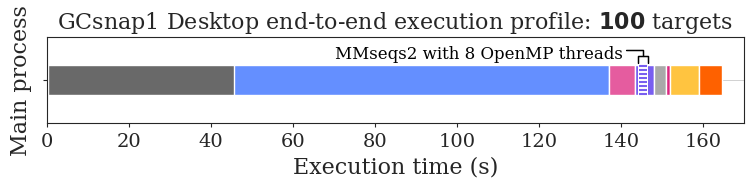

In [10]:
df_gc = df_gcsnap1.copy()

# font_size of this plot to align with previous
font_size = 16

# rename columns
df_gc.rename(columns={'task': 'Substep'}, inplace=True)
df_gc.rename(columns={'total time (s)': 'Elapsed'}, inplace=True)
df_gc.rename(columns={'repetition': 'Repetition'}, inplace=True)
df_gc['Rank'] = 0

#only keep repetition 1
df_gc = df_gc[df_gc['Repetition'] == 1].copy()

# the plot
cols = ['Substep', 'Elapsed', 'Repetition', 'Rank']

# Define function order (substeps)
function_order = [
    'Mapping',
    'Parse Assemblies',
    'Sequences',
    'Find Families',
    'Annotate Functions',
    'Find Operons',
    'Taxonomies',
    'Produce Output',
    'Step 1: Collect' 
]

# Filter relevant substeps
df_filtered = df_gc[df_gc['Substep'].isin(function_order)].copy()
df_filtered = df_filtered[cols].copy()

#Take the mean eplapsed time over repetitions
df_avg = df_filtered.groupby(['Rank', 'Substep']).agg({
    'Elapsed': 'mean'  # Use mean for elapsed times
}).reset_index()

# Sequences are not in the collected times for GCsnap1, so we add them manually by subtracting assemblies and mapping from Step 1: Collect
df_avg.loc[df_avg['Substep'] == 'Sequences', 'Elapsed'] = df_avg.loc[df_avg['Substep'] == 'Step 1: Collect', 'Elapsed'].values[0] - df_avg.loc[df_avg['Substep'] == 'Parse Assemblies', 'Elapsed'].values[0] - df_avg.loc[df_avg['Substep'] == 'Mapping', 'Elapsed'].values[0]
# remove collect time fomr df_avg and function_order
df_avg = df_avg[df_avg['Substep'] != 'Step 1: Collect'].copy()
function_order.remove('Step 1: Collect')

# some are super short and barly visible set elapsed time to minimal value
min_value = 1
df_avg.loc[df_avg['Elapsed'] < min_value, 'Elapsed'] = min_value

# Add start colum, order substeps in df_avg by function_order and comupte starttime compared to the previous
df_avg['Start'] = 0
df_avg = df_avg.sort_values(by=['Substep'], key=lambda x: x.map({k: i for i, k in enumerate(function_order)})).copy()
# the start point is the cumulative sum of all previous substeps
df_avg['Start'] = df_avg['Elapsed'].shift(1).cumsum()
# Set the start of the first substep to 0
df_avg.loc[df_avg['Substep'] == function_order[0], 'Start'] = 0.3

print(df_avg)
# print the sum of elapsed time
print(df_avg['Elapsed'].sum())

# Assign colors from IBM palette
function_colors = dict(zip(function_order, colors))

# Create figure
fig, ax = plt.subplots(figsize=(fig_width, fig_height*0.25))

# Ensure ranks are sorted (excluding Rank 0 as master does no work)
all_ranks = sorted(df_aligned['Rank'].unique(), reverse=True)

# Plot bars
for _, row in df_avg.iterrows():
    ax.barh(row['Rank'], row['Elapsed'], left=row['Start'], height=0.14,
            color=function_colors[row['Substep']],
            label=row['Substep'] if row['Substep'] in function_order else '')

plt.xlabel('Execution time (s)', fontsize=font_size)
make_grid(ax, plt, True, False)

# no legend (take the one from the previous plot)

# Set the title
plt.title(r'GCsnap1 Desktop end-to-end execution profile: $\bf{100}$ targets', loc='center',fontsize=font_size)

# Format y-axis ticks
formatter(ax)

# Remove all default y-ticks first
ax.set_yticks([])  # This removes all y-axis ticks
# Manually set just one y-tick in the center
middle_tick = [0]  # Set this to the actual position where your bar is
ax.set_yticks(middle_tick)  # Apply the tick position
# **Ensure Matplotlib does NOT auto-format numbers**
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: ""))  # Completely removes extra numbers
# **Remove the y-axis label**
ax.set_ylabel('Main process', fontsize=font_size)  # Add a custom label
# **Manually control bar height** by setting a specific y-limit
ax.set_ylim(-0.2, 0.2)  # Adjust to center the single bar properly
ax.set_xticklabels(ax.get_xticklabels(), fontsize=font_size)
ax.tick_params(axis='x', labelsize=14) 

# ad white lines to emphasis parallel threads
x_pos = 145.4
x_length = 1.3
y_pos = -0.063

# Make White
# Create a square using a Rectangle patch
square = patches.Rectangle((x_pos - x_length, y_pos - 0.1 ), 2 * x_length, 1.2,  # Position (x, y), width, height
                               linewidth=2, edgecolor='none', facecolor='white')
# Add the square to the plot
ax.add_patch(square)

for i in range(0, 8):
    ax.add_line(lines.Line2D([x_pos - x_length + 0.3, x_pos + x_length - 0.3], [y_pos + (i*0.018), y_pos + (i*0.018)], 
                             color=ibm_colors_hex[1], linewidth=1.5, solid_capstyle='butt'))


ax.text(x_pos-40, 0.082, 'MMseqs2 with 8 OpenMP threads', 
            rotation=0, fontsize=12, ha='center', va='bottom', color=color)

for i in range(len(arrow_x_positions)):
    color = 'black'
    line_width = 0.85
    height = 0.03
    lenght = 1.2
    y_pos = 0.11

    # Left vertical line
    ax.add_line(lines.Line2D([x_pos - lenght, x_pos - lenght], [y_pos, y_pos - height], color=color, linewidth=line_width))
    # Right vertical line
    ax.add_line(lines.Line2D([x_pos + lenght, x_pos + lenght], [y_pos, y_pos - height], color=color, linewidth=line_width))
    # Horizontal connecting line at the top
    ax.add_line(lines.Line2D([x_pos - lenght, x_pos + lenght], [y_pos, y_pos], color=color, linewidth=line_width))
    # **Middle vertical line**
    ax.add_line(lines.Line2D([x_pos , x_pos ], [y_pos, y_pos + height], color=color, linewidth=line_width))
    # Horizontal line at the top
    ax.add_line(lines.Line2D([x_pos - lenght*3.5, x_pos], [y_pos + height, y_pos + height], color=color, linewidth=line_width))
    

# set x axis limits
plt.xlim(0, 170)

# Save and show
finisher('profile_gcsnap1', plt)

